In [ ]:
!git clone --single-branch --branch v0.2dev https://github.com/scikit-learn-contrib/py-earth.git
%cd py-earth
!python setup.py install --cythonize

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
from pyearth import Earth
from xgboost import XGBClassifier
import time

In [ ]:
data = pd.read_csv('stats_unique_no_missing.csv')
data.head()

Unnamed: 0    player_name               team  conf  GP  Min_per   Ortg  \
0        4589  Pooh Williams           Utah St.   WAC  32     64.0  108.3   
1        4590   Nick Rodgers             Butler  Horz  11      1.0  121.1   
2        4591     Dana Smith           Longwood   ind  27     81.8   99.8   
3        4594  Carlos Strong  Boston University    AE  35     76.2  118.1   
4        4595  Sherrod Smith  Boston University    AE  29      9.5   60.7   

    usg   eFG  TS_per  ...    oreb    dreb    treb     ast     stl     blk  \
0  18.1  53.0   53.33  ...  0.4688  1.3750  1.8438  2.1875  0.5938  0.2188   
1  16.8  75.0   75.00  ...  0.0000  0.0000  0.0000  0.0909  0.0000  0.0000   
2  27.7  49.9   53.76  ...  2.1481  4.9259  7.0741  2.4074  0.8148  0.4815   
3  16.4  58.8   60.93  ...  1.3429  3.2286  4.5714  1.8000  1.6571  0.4000   
4   6.9   8.3   14.93  ...  0.1379  0.5862  0.7241  0.2069  0.1034  0.0345   

       pts  Unnamed: 64  Unnamed: 65  drafted  
0   8.7812      Combo G     7.300850      0.0  
1   0.5455      Pure PG    12.267400      0.0  
2  17.5556       Wing F     5.581250      0.0  
3  10.8571      Combo G     6.583070      0.0  
4   0.1724       Wing G     0.844851      0.0  

[5 rows x 63 columns]

In [ ]:
cols = list(data.columns)
categorical_cols = []
numerical_cols = []
for item in cols:
  if data[item].dtype == object:
    categorical_cols.append(item)
  else:
    numerical_cols.append(item)

In [ ]:
categorical_cols

['player_name', 'team', 'conf', 'yr', 'ht', 'num', 'type', 'Unnamed: 64']

In [ ]:
data = data.set_index('player_name')

In [ ]:
data = data.drop(['Unnamed: 64', 'Unnamed: 65', 'rimmade+rimmiss', 'midmade+midmiss',
       'dunksmiss+dunksmade', 'num', 'type'], axis=1)
data_dummies = pd.get_dummies(data)

In [ ]:
y = data_dummies.drafted
X = data_dummies.drop('drafted', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=45)

In [ ]:
train = pd.concat([X_train, y_train], axis=1)

class0 = train.loc[train['drafted'] == 0,:]
class1 = train.loc[train['drafted'] == 1,:]
spw = len(class0)/len(class1)
print(spw)

39.346858638743456


In [ ]:
start_time = time.time()
param_grid = {'n_estimators':[25,100,500],
              'max_depth': [6,7,8],
              'learning_rate': [0.01,0.1,0.2],
              'gamma': [0.1,0.25,0.5],
              'reg_lambda':[0,0.01,0.001]}

cv = StratifiedKFold(n_splits=2,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic', random_state=45, scale_pos_weight=spw), 
                              param_grid = param_grid, scoring='recall', verbose=1, n_jobs=-1, cv=cv)

optimal_params.fit(X_train,y_train)
print(optimal_params.best_params_,optimal_params.best_score_)
print("Time taken = ", (time.time()-start_time)/60, " minutes")

Fitting 2 folds for each of 243 candidates, totalling 486 fits
{'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 25, 'reg_lambda': 0} 0.7447643979057592
Time taken =  52.89637066523234  minutes


In [66]:
model = XGBClassifier(objective = 'binary:logistic', random_state=45, gamma=0.1, learning_rate = 0.01,
                      max_depth=6, n_estimators=25 ,reg_lambda=0, scale_pos_weight=spw).fit(X_train, y_train)

In [67]:
cross_val_ypred = cross_val_predict(model, X_train, y_train, cv = 5, method = 'predict_proba')

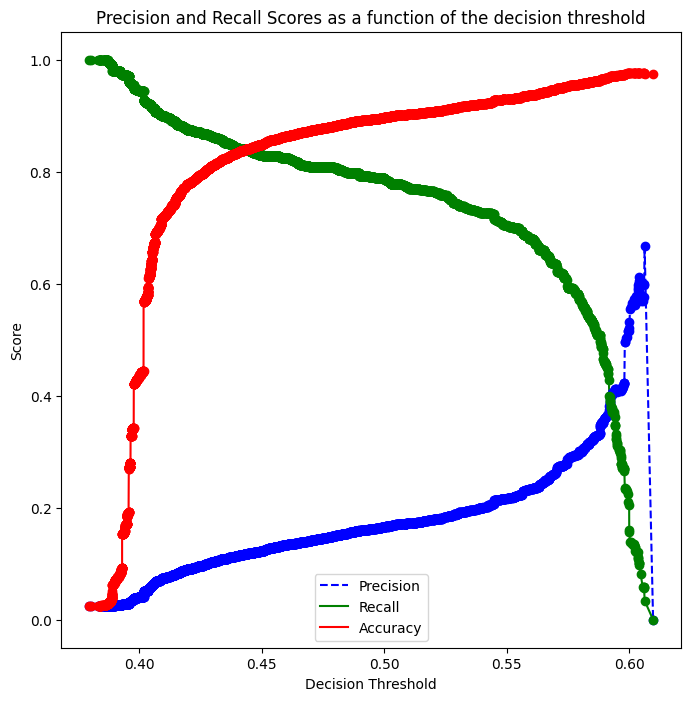

In [68]:
p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = cross_val_ypred[:,1] > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, acc, "r-", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Accuracy:  81.79075425790754
ROC-AUC:  0.9671890541588125
Precision:  0.11812883918727358
Recall:  0.981675392670157


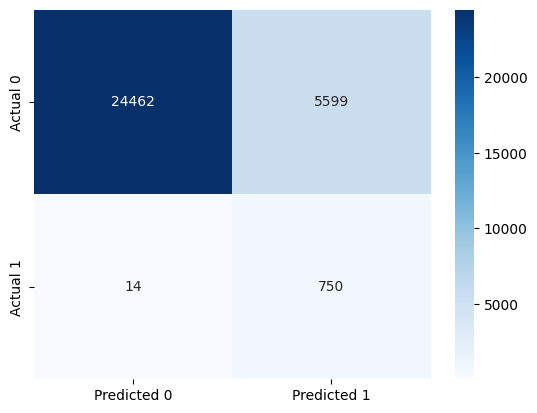

In [70]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.43

y_pred_prob = model.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  81.06174882000876
ROC-AUC:  0.8906321916097578
Precision:  0.11129220023282888
Recall:  0.864376130198915


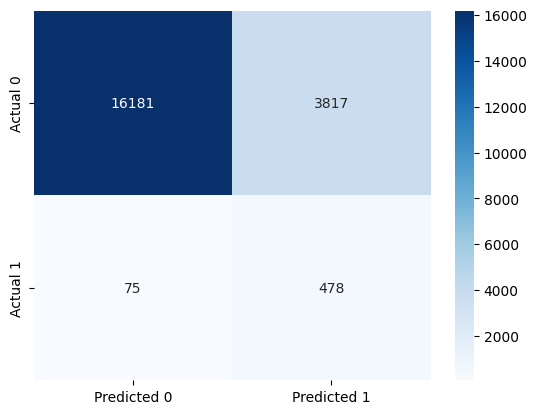

In [71]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.43

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');